# Figures S2 and S3: OHC hindcats vs observations

- Columns of figures are plotted separately
- For differences in S2 and S3 adjust variable nyears in respective column to change number of years used for the last panel

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import cmocean as cmo
import numpy as np
import cartopy.crs as ccrs
import cartopy
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from scipy.interpolate import griddata
from scipy.io import loadmat
import datetime
# from datetime import datetime
import string

import sys
sys.path.append("./")  # adds upper level to working directory\n
from utils_iohc_ummenhofer2020 import deseason,ohc_anomaly,cut_indo,plot_map,finished_plot,add_ipo_bar,monte_carlo


# where to save plots
plotsave = 'plots/'
datapath = '/vortexfs1/share/clidex/data/'

In [2]:
# baseline period for anomalies
base = ['1960-01-01','2012-12-31'] # paper

# values for heat content calculation
cp = 3994 # heat capacity
rho = 1029 # reference density
# cp and rho from https://xgcm.readthedocs.io/en/latest/example_eccov4.html

# Ishii
## Derive and save OHC anomaly

In [ ]:
# Ishii

ishii = xr.open_dataset(datapath + 'obs/Ishii/ishii_20E_180E_72S_35N.nc')
#associated cell area
area = xr.open_dataset(datapath + 'obs/Ishii/ishii_gridarea_20E_180E_72S_35N.nc')

# need mask for Indian ocean
xm,ym = np.meshgrid(np.arange(-179.5,180.5,1),np.arange(-89.5,90.5,1))
mask_ind = griddata((mask['NAV_LON'].values.ravel(),mask['NAV_LAT'].values.ravel()),
                      mask['tmaskind'].values.ravel(),(xm,ym),'linear')

# set nan to 0
mask_ind[np.isnan(mask_ind)]=0
mask_ind.shape
# rearrange data to match longitudes of oras5
mask1 = np.squeeze(mask_ind[:,np.where(xm[0,:]>=0)])
mask2 = np.squeeze(mask_ind[:,np.where(xm[0,:]<0)])
mask_ind2 = np.concatenate((mask1,mask2),axis=1)
# create xarray for mask
mask_ishii = xr.DataArray(mask_ind2, dims=['lat', 'lon'],coords={'lon': np.arange(0.5,360.5,1),'lat': ym[:,0]})

mask_ishii = mask_ishii.sel(lon=slice(20,180),lat=slice(-72,35))

# cut out Indian Ocean and multiply by area
# ishii_ind_ext = ishii*mask.values*area['cell_area'].values
# ishii_ind_ext = ishii_ind_ext.where(ishii_ind_ext['var80']>0,drop=True)

In [ ]:
###############################################################
###############################################################
###############################################################
# derive mid-layer value and layer thickness for integration
dz = np.diff(ishii['depth'])
tempdz = (ishii['var80'][:,:-1,:,:].values + ishii['var80'][:,1:,:,:].values)/2
depthdz = (ishii.depth[:-1].values + ishii.depth[1:].values)/2

# create array for multiplication
dummy = np.tile(dz,(ishii['var80'].shape[0],ishii['var80'].shape[2],ishii['var80'].shape[3],1))
dzm = np.moveaxis(dummy,-1,1)

# multiply with layer thickness and create xarray
tempz2 = tempdz*dzm
temp = xr.DataArray(tempz2,
                    dims=['time','depth','lat', 'lon'],
                    coords={'lon': ishii.lon.values,
                           'lat': ishii.lat.values,
                           'time': ishii.time.values,
                           'depth': depthdz}).to_dataset(name='temp')

###############################################################
###############################################################
###############################################################
# cut upper 700m & derive OHC
# base = ['1958-01-01','2012-01-01']

dummy = temp.sel(depth=slice(0,701))
ohc_ishii = dummy.sum(dim=['depth'])*cp*rho
ohca_ishii = ohc_ishii.groupby('time.month')-ohc_ishii.sel(
            time=slice(*base)).groupby('time.month').mean('time')
# somehow needed to do that in a separate step
ohca_ishii = ohca_ishii.drop('month')

#########################################
# save to netcdf
# ohca_ishii.rename({'temp':'OHC700'}).to_netcdf('./data/ohca700_ishii.nc')
# del ishii_ind,ohc_ishii,dummy,temp

## Load saved OHC anomaly & monte-carlo for significance

In [50]:
ohca_ishii = xr.open_dataset('../data/ohca700_ishii.nc')

# monte carlo simulation for significance
ishii_p5 = {}
ishii_p95 = {}
[ishii_p5['10yr'],ishii_p95['10yr']] = monte_carlo(ohca_ishii['OHC700'],duration=10*12,n=1000,pval=5,timevar='time')
[ishii_p5['7yr'],ishii_p95['7yr']] = monte_carlo(ohca_ishii['OHC700'],duration=7*12,n=1000,pval=5,timevar='time')
[ishii_p5['3yr'],ishii_p95['3yr']] = monte_carlo(ohca_ishii['OHC700'],duration=3*12,n=1000,pval=5,timevar='time')

# save to file
np.save('../data/ishii_percentiles_two_tail_90p_base_1960_2012.npy',[ishii_p5,ishii_p95])

ishii_p5,ishii_p95 = np.load('../data/ishii_percentiles_two_tail_90p_base_1960_2012.npy',allow_pickle=True)


# IAP (Cheng)

In [45]:
# load data
iap = xr.open_dataset(datapath+'obs/OHC_temp_Chen/ohc/OHC700_IAP_20E_160W_72S_35N.nc')

# somehow time did not read properly --> create new time vector
time = pd.date_range('1940-01-01','2019-12-01' , freq='MS')
iap['time'] = time

# derive anomaly & deseason
iap_ind = deseason(iap,timevar='time',refperiod=base)

# # monte carlo simulation for significance
# iap_p5 = {}
# iap_p95 = {}
# [iap_p5['10yr'],iap_p95['10yr']]  = monte_carlo(iap_ind['OHC700'],duration=10*12,n=1000,pval=5,timevar='time')
# [iap_p5['7yr'],iap_p95['7yr']]  = monte_carlo(iap_ind['OHC700'],duration=7*12,n=1000,pval=5,timevar='time')
# [iap_p5['3yr'],iap_p95['3yr']]  = monte_carlo(iap_ind['OHC700'],duration=3*12,n=1000,pval=5,timevar='time')

# # save to file
# np.save('../data/iap_percentiles_two_tail_90p_base_1960_2012.npy',[iap_p5,iap_p95])

iap_p5,iap_p95 = np.load('../data/iap_percentiles_two_tail_90p_base_1960_2012.npy',allow_pickle=True)


# Plot decadal averages (like Fig3)

In [46]:
def plot_decave(ds,p95,p5,var,timevar,nyears):
    """
    Plots panels for decadal averages (stippling for significance)
    
    INPUT:
    ds (xarray):   data array containing quantitiy to plot
    p95 (dict):    dictionary with numpy arrays containing upper threshold for significance
    p5 (dict):     dictionary with numpy arrays containing lower threshold for significance
    nyears (int):  number of years considered for last panel (varies due to different lengths of datasets)           
    """
    
    plt.rcParams.update({'font.size': 8})
    fig,ax=plt.subplots(nrows=6,figsize=(5,10),
                      subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=120)))
    plt.subplots_adjust(hspace=0.2)

    vmin=-1.5
    vmax=1.5
    cmap = plt.get_cmap('RdBu_r',len(np.arange(-1.2,1.2,0.1)))

    # loop over datasets and plot
    for year,i in zip(np.arange(1960,2020,10),range(6)):
        if i==5:
            year2 = year+nyears-1
            dummy_p95 = p95[str(nyears)+'yr']
            dummy_p5 = p5[str(nyears)+'yr']
        else:
            year2 = year+9
            dummy_p95 = p95['10yr']
            dummy_p5 = p5['10yr']
        #print(year,year2)
        
        time_bnds = [str(year) + '-01-01',str(year2) + '-12-31']
        cc= (ds.sel(time=slice(*time_bnds)).mean(timevar)[var]/1e09).plot(ax=ax[i],cmap=cmap,
                                                                                vmin=vmin,vmax=vmax,
                                                                                transform=ccrs.PlateCarree(),
                                                                               add_colorbar=False)
        # significance
        mask = (xr.zeros_like(ds[var].sel(time=slice(*time_bnds)).mean('time')).values)*np.nan
        dummy = (ds[var].sel(time=slice(*time_bnds)).mean('time').values-dummy_p95)
        mask[dummy>=0]=1
        dummy = (ds[var].sel(time=slice(*time_bnds)).mean('time').values-dummy_p5)
        mask[dummy<=0]=1
        mask[np.isnan(ds[var][0,::])] = np.nan
        ax[i].pcolor(ds.lon,ds.lat,mask,hatch='...',alpha=0.,transform=ccrs.PlateCarree())

        # make plot pretty
        ax[i].coastlines(resolution='50m')
        ax[i].add_feature(cartopy.feature.LAND, color='lightgray')
        ax[i].set_title(str(year) + '-' + str(year2),fontsize=8,loc='left',weight='bold')
        ax[i].tick_params(axis="x", direction="out")
        ax[i].tick_params(axis="y",direction="out")
        ax[i].set_extent((30,181,-40,31),crs=ccrs.PlateCarree())
        ############ adjust labels for subplots #########################
        ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=False,
                           xlocs=[40,80,120,160,200,-160],ylocs=range(-60,60,30))
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                    xlocs=[40,80,120,160],ylocs=range(-60,60,30))
        gl.ylabels_right = False
        gl.xlabels_top = False
        # ylabels
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size':10}
        # xlabels
        if i==5:
            gl.xformatter = LONGITUDE_FORMATTER
            gl.xlabel_style = {'size':10}
        else:
            gl.xlabels_bottom = False 

        t = ax[i].text(0.02, 0.82, string.ascii_lowercase[i]+')', transform=ax[i].transAxes, 
                size=8, weight='bold')
        t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))


    # add colorbar
    cbaxes = fig.add_axes([0.78, 0.3, 0.02, 0.4]) 
    cb = plt.colorbar(cc,orientation='vertical', cax = cbaxes,extend='both',
                      label='OHC anomaly [$10^{9}\,$J]') 

    # fix title for bottom panels
#     ax[5].set_title('2010-'+str(int(ds['time'][-1].dt.year.values)),fontsize=8,loc='left',weight='bold')
    ax[5].set_title('2010-'+str(2009+nyears),fontsize=8,loc='left',weight='bold')

    return fig
    # finished_plot(fig,plotsave+'ohc_map_decadal_ishii.png')

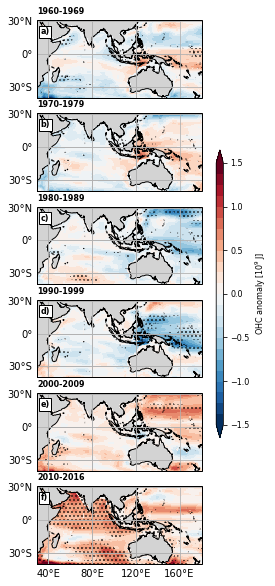

In [47]:
# call plotting function
fig = plot_decave(iap_ind,iap_p95,iap_p5,var='OHC700',timevar='time',nyears=7)
# finished_plot(fig,plotsave+'ohc_map_decadal_iap_base_1960_2012_0_700m_stippling_until_2016_V2.png')

## Ishii

Somehow the stippling did not work with function above. Not sure why (something to do with mask I think)!

Text(0.0, 1.0, '2010-2016')

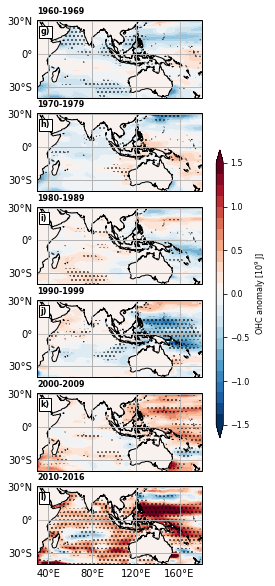

In [51]:
plt.rcParams.update({'font.size': 8})
fig,ax=plt.subplots(nrows=6,figsize=(5,10),
                  subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=120)))
plt.subplots_adjust(hspace=0.2)

# vmin=-0.8
# vmax=0.8
vmin=-1.5
vmax=1.5
cmap = plt.get_cmap('RdBu_r',len(np.arange(-1.2,1.2,0.1)))
var='OHC700'
ds = ohca_ishii
nyears = 7   # numbr of years for last panel
 
# loop over datasets and plot
for year,i in zip(np.arange(1960,2020,10),range(6)):
    if i==5:
        year2 = year+nyears-1
        dummy_p95 = ishii_p95[str(nyears)+'yr']
        dummy_p5 = ishii_p5[str(nyears)+'yr']
    else:
        year2 = year+9
        dummy_p95 = ishii_p95['10yr']
        dummy_p5 = ishii_p5['10yr']
    #print(year,year2)
    time_bnds = [str(year) + '-01-01',str(year2) + '-12-31']
    cc= (ds.sel(time=slice(*time_bnds)).mean('time')[var]/1e09).plot(ax=ax[i],cmap=cmap,
                                                                            vmin=vmin,vmax=vmax,
                                                                            transform=ccrs.PlateCarree(),
                                                                           add_colorbar=False)
    # significance
    mask = (xr.zeros_like(ds[var].sel(time=slice(*time_bnds)).mean('time')).values)*np.nan
    dummy = (ds[var].sel(time=slice(*time_bnds)).mean('time').values-dummy_p95)
    mask[dummy>=0]=1
    dummy = (ds[var].sel(time=slice(*time_bnds)).mean('time').values-dummy_p5)
    mask[dummy<=0]=1
    mask[ds[var][0,::].values==0] = np.nan
    mask[ds[var][0,::].values==0] = np.nan
    ax[i].pcolor(ds.lon,ds.lat,mask,hatch='...',alpha=0.,transform=ccrs.PlateCarree())
    
    ax[i].coastlines(resolution='50m')
    ax[i].add_feature(cartopy.feature.LAND, color='lightgray')
    ax[i].set_title(str(year) + '-' + str(year2),fontsize=8,loc='left',weight='bold')
    ax[i].tick_params(axis="x", direction="out")
    ax[i].tick_params(axis="y",direction="out")
    ax[i].set_extent((30,181,-40,31),crs=ccrs.PlateCarree())
    ############ adjust labels for subplots #########################
    ############ adjust labels for subplots #########################
    ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=False,
                           xlocs=[40,80,120,160,200,-160],ylocs=range(-60,60,30))
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                    xlocs=[40,80,120,160],ylocs=range(-60,60,30))
    gl.ylabels_right = False
    gl.xlabels_top = False
    # ylabels
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size':10}
    # xlabels
    if i==5:
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size':10}
    else:
        gl.xlabels_bottom = False 

    t = ax[i].text(0.02, 0.82, string.ascii_lowercase[i+6]+')', transform=ax[i].transAxes, 
            size=8, weight='bold')
    t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))

# add colorbar
cbaxes = fig.add_axes([0.78, 0.3, 0.02, 0.4]) 
cb = plt.colorbar(cc,orientation='vertical', cax = cbaxes,extend='both',label='OHC anomaly [$10^{9}\,$J]') 

# fix title for bottom panels
# ax[5].set_title('2010-'+str(int(ds['time'][-1].dt.year.values)),fontsize=8,loc='left',weight='bold')
ax[5].set_title('2010-'+str(2009+nyears),fontsize=8,loc='left',weight='bold')


# fig,mask = plot_decave(ohca_ishii,ishii_p5,ishii_p95,var='temp',timevar='time')
# finished_plot(fig,plotsave+'ohc_map_decadal_ishii_base_1960_2012_0_700m_stippling_until_2012_V2.png')

## K003

In [52]:
# load data
datapath2 = datapath+'publications/IOHC_Ummenhofer/'
ohc_k003_700 = deseason(xr.open_dataset(datapath2+'k003_ohc_zint_700m.nc'),refperiod=base)['votemper'].sel(y=slice(200,None))

In [56]:
plt.rcParams.update({'font.size': 8})
fig,ax=plt.subplots(nrows=6,figsize=(5,10),
                  subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=120)))
plt.subplots_adjust(hspace=0.2)

vmin=-1.5
vmax=1.5
cmap = plt.get_cmap('RdBu_r',len(np.arange(-1.2,1.2,0.1)))
nyears = 7  # how many years for last panel

# need to change longitude values in order to have hatching plotted properly
lon = ohc_k003_700.nav_lon.values
lon[lon<0] = lon[lon<0]+360
lon=lon[300,:]
lat=ohc_k003_700.nav_lat[:,200].values

# loop over datasets and plot
j=0
ll = 0
ds = ohc_k003_700
p95 = dict(np.load('../data/fig3_k003_p95_two_tail_90p_base_1960_2012_n1000.npz'))
p5 = dict(np.load('../data/fig3_k003_p5_two_tail_90p_base_1960_2012_n1000.npz'))

# loop over time
for year,i in zip(np.arange(1960,2020,10),range(6)):
    if i==5:
        year2 = year+nyears-1
        dummy_p95 = p95[str(nyears)+'yr']
        dummy_p5 = p5[str(nyears)+'yr']
    else:
        year2 = year+9
        dummy_p95 = p95['10yr']
        dummy_p5 = p5['10yr']
    #print(year,year2)
    time_bnds = [str(year) + '-01-01',str(year2) + '-12-31']
    hh = ax[i].pcolormesh(lon,lat,(ds/1e09).sel(time_counter=slice(*time_bnds)).mean('time_counter'),
                       transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax)
#     print('ohc done, now stippling')
    # significance
    mask = (xr.zeros_like(ds.sel(time_counter=slice(*time_bnds)).mean('time_counter')).values)*np.nan
    dummy = (ds.sel(time_counter=slice(*time_bnds)).mean('time_counter').values-dummy_p95)
    mask[dummy>=0]=1
    dummy = (ds.sel(time_counter=slice(*time_bnds)).mean('time_counter').values-dummy_p5)
    mask[dummy<=0]=1
    mask[ds[0,::].values==0] = np.nan
    ax[i].pcolor(lon,ds.nav_lat,mask,hatch='...',alpha=0.,transform=ccrs.PlateCarree())
#     print('stippling done')


    ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=False,
                       xlocs=[40,80,120,160,200],ylocs=range(-60,60,30))
    ax[i].coastlines(resolution='50m')
    ax[i].add_feature(cartopy.feature.LAND, color='lightgray')
    ax[i].set_title(str(year) + '-' + str(year2),fontsize=8,loc='left',weight='bold')
    ax[i].tick_params(axis="x", direction="out")
    ax[i].tick_params(axis="y",direction="out")
    ax[i].set_extent((30,181,-40,31),crs=ccrs.PlateCarree())
    ############ adjust labels for subplots #########################
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                    xlocs=[40,80,120,160],ylocs=range(-60,60,30))
    gl.ylabels_right = False
    gl.xlabels_top = False
    # ylabels
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size':10}
    # xlabels
    if i==5:
        gl.xformatter = LONGITUDE_FORMATTER
        gl.xlabel_style = {'size':10}
    else:
        gl.xlabels_bottom = False 
    t = ax[i].text(0.02, 0.82, string.ascii_lowercase[i+12]+')', transform=ax[i].transAxes, 
            size=8, weight='bold')
    t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))
#     print(str(year))

# add colorbar
cbaxes = fig.add_axes([0.78, 0.3, 0.02, 0.4]) 
cb = plt.colorbar(cc,orientation='vertical', cax = cbaxes,extend='both',label='OHC anomaly [$10^{9}\,$J]') 

# fix title for bottom panels
# ax[5].set_title('2010-'+str(int(ds['time_counter'][-1].dt.year.values)),fontsize=8,loc='left',weight='bold')
ax[5].set_title('2010-'+str(2009+nyears),fontsize=8,loc='left',weight='bold')


# fig,mask = plot_decave(ohca_ishii,ishii_p5,ishii_p95,var='temp',timevar='time_counter')
# finished_plot(fig,plotsave+'ohc_map_decadal_hindcast_base_1960_2012_0_700m_stippling_until_2012.png')

1960
1970
1980
1990
2000
2010


Text(0.0, 1.0, '2010-2016')

Error in callback <function flush_figures at 0x2aaadf0bb170> (for post_execute):


KeyboardInterrupt: 